# TMA Analysis code supporting technote SITCOMTN-112
Craig Lage - 19-Feb-24

This notebook attempts to answer the following questions associated with the TMA: 

(1) What is the tracking error at the InPosition timestamp?\
(2) How long does the TMA take to settle after the InPosition timestamp?\
(3) What is the RMS tracking jitter for a 15 second period after the InPosition timestamp?\
(4) What is the time from the beginning of a slew until the TMA is InPosition and settled?



# Note that this must use the summit_utils tickets/DM-42039 branch until this branch is merged.

# Prepare the notebook

In [1]:
# Directory to store the data
from pathlib import Path
dataDir = Path("./plots")
dataDir.mkdir(exist_ok=True, parents=True)

# You can include a list of different days and blocks,
# including more than one block on the same day, if desired
# You can also create a loop to build this list.
#dayBlockPairs = [[20231214, 146], [20231215, 146]]
dayBlockPairs = [[20231220, 146], [20231221, 146]]
#dayBlockPairs = [[20240212, 190], [20240212, 225]]


In [2]:
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages
import pickle as pkl
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
from lsst_efd_client import EfdClient
from lsst.summit.utils import getCurrentDayObs_int, dayObsIntToString
from lsst.summit.utils.tmaUtils import TMAEventMaker, plotEvent, getAzimuthElevationDataForEvent
from lsst.summit.utils.blockUtils import BlockParser
from lsst.summit.utils.efdUtils import getEfdData

In [3]:
client = EfdClient("usdf_efd")
eventMaker = TMAEventMaker()

In [4]:
def findTimeSettled(event, azError, elError, err_limit = 0.01, N=10):
    # This attempts to quatify when the TMA has settled.
    azRolling = azError.rolling(N).sum() / N
    elRolling = elError.rolling(N).sum() / N
    goodAzRolling = azRolling[abs(azRolling) < err_limit]
    goodElRolling = elRolling[abs(elRolling) < err_limit]
    if (len(goodAzRolling) == 0) or (len(goodElRolling) == 0):
        timeSettled = event.end
    else:
        badAzRolling = azRolling[abs(azRolling) > err_limit]
        badElRolling = elRolling[abs(elRolling) > err_limit]
        if len(badElRolling) == 0:
            timeSettledEl = event.begin
        else:
            timeSettledEl = Time(badElRolling.index[-1])
        if len(badAzRolling) == 0:
            timeSettledAz = event.begin
        else:
            timeSettledAz = Time(badAzRolling.index[-1])
        timeSettled = max(timeSettledEl, timeSettledAz)
    return timeSettled

def getPreviousSlew(events, seqNum):
    # Find the previous slew associated with an event
    for event in events:
        if event.seqNum == seqNum - 1:
            return event

def filterBadValues(values, maxDelta=0.05):
    # Find non-physical points and replace with extrapolation 
    # This is in summit_utils, but is reproduced here to allow changes
    badCounter = 0
    consecutiveCounter = 0
    lastIndexReplaced = 0
    for i in range(2, len(values)):
        if consecutiveCounter > 3:
            print("Hitting consecutive counter limit")
            consecutiveCounter = 0
            continue
        if abs(values[i] - values[i-1]) > maxDelta:
            # This is a bogus value - replace it with an extrapolation                                                            
            # Of the preceding two values
            if i == lastIndexReplaced + 1:
                consecutiveCounter += 1
            else:
                consecutiveCounter = 0
            values[i] = (2.0 * values[i-1] - values[i-2])
            badCounter += 1
            lastIndexReplaced = i
    return badCounter


# Make a tracking plot for a single event.

In [ ]:
%matplotlib inline
dayObs = 20231220
seqNum = 431
event = eventMaker.getEvent(dayObs, seqNum)
fig = plt.figure(figsize=(10, 8))
plotEvent(client, event, fig, doFilterResiduals=True)
plt.savefig(str(dataDir / f"RubinTV_Tracking_{dayObs}-{seqNum}.png"))

# Now cycle through many events plotting the tracking errors, and getting the data for the slew time histogram and the jitter error histograms.

In [5]:
# These are for plotting the slew time distributions
slewTimesInPosition = []
slewTimesSettled = []
slewDistance = []
azVals = []
elVals = []
shifts = []

rmsError0s = [] # This is the error at the inPosition

# These are for plotting the jitter distributions
#We do this for several delays after the InPosition
delays = [0.0, 1.0, 2.0, 3.0]
rmsErrors = {}
for delay in delays:
    rmsErrors[delay] = []

timeToSettles = []

firstDayObs = dayBlockPairs[0][0]
lastDayObs = dayBlockPairs[-1][0]

pdf = PdfPages(str(dataDir / f"Mount_Jitter_Plots_MTMount_{firstDayObs}-{lastDayObs}.pdf"))
fig = plt.figure(figsize=(10, 8))


for i, [dayObs, blockNum] in enumerate(dayBlockPairs):

    events = eventMaker.getEvents(dayObs)
    these_events = []
    for e in events:
        for b in e.blockInfos:
            if b.blockNumber==blockNum:
                these_events.append(e)
                break
    tracks = [e for e in these_events if e.type.name=="TRACKING"]
    for track in tracks:
        try:
            # Get the information from the previous slew
            try:
                seqNum = track.seqNum
                previous_slew = getPreviousSlew(these_events, seqNum)
                if previous_slew.type.name == 'SLEWING':
                    azimuthData, elevationData = getAzimuthElevationDataForEvent(
                        client, previous_slew)
                    azShift = abs(azimuthData['actualPosition'].iloc[0]
                                  - azimuthData['actualPosition'].iloc[-1])
                    elShift = abs(elevationData['actualPosition'].iloc[0]
                                  - elevationData['actualPosition'].iloc[-1])
                    azShiftMod = azShift * np.cos(elevationData['actualPosition'].iloc[0]*np.pi/180.0)
                    shift = np.sqrt(elShift*elShift + azShiftMod*azShiftMod)
                    if shift < 0.2 or shift > 10.0:
                        continue
                else:
                    # If the previous event wasn't a slew, we won't use this track.
                    print(f"Discarding {dayObs}-{seqNum} because it isn't preceded by a slew")
                    continue
            except:
                print(f"Discarding {dayObs}-{seqNum} because of an error processing the slew")
                continue
    
            # Now get the track information
            azimuthData, elevationData = getAzimuthElevationDataForEvent(
                    client, track, postPadding = -1.0)
            azError = azimuthData['azError'].values
            elError = elevationData['elError'].values
            azBadValues = filterBadValues(azError)
            elBadValues = filterBadValues(elError)
            azimuthData['azError'] = azError
            elevationData['elError'] = elError
            azError = azimuthData['azError']
            elError = elevationData['elError']

            initialAzRms = np.sqrt(np.mean(azError**2))
            initialElRms = np.sqrt(np.mean(elError**2))
            if initialAzRms > 10.0 or initialElRms > 10.0:
                print(f"Discarding {dayObs}-{seqNum} because the slew is out of limits")
                continue
    
            # Save the slewing information
            slewDistance.append(shift)
            slewTimesInPosition.append(previous_slew.duration)
            azVals.append(azimuthData['actualPosition'].iloc[0])
            thisEl = elevationData['actualPosition'].iloc[0]
            elVals.append(thisEl)
            rmsError0s.append(max(azError.iloc[0], elError.iloc[0]))
    
            # Now calculate the settling time
            timeSettled = findTimeSettled(track, azError, elError)
            timeToSettle = timeSettled.unix_tai - track.begin.unix_tai
            timeToSettles.append(timeToSettle)
            slewTimesSettled.append(previous_slew.duration + timeToSettle)

            # Now calculate the RMS error from the inPosition time
            # plus an offset and for 15 seconds afterward
            for delay in delays:
                start = track.begin + TimeDelta(delay, format='sec')
                end = start + TimeDelta(15.0, format='sec')
                thisAzData = azimuthData.loc[start.isot:end.isot]
                thisAzError = thisAzData['azError']
                thisElData = elevationData.loc[start.isot:end.isot]
                thisElError = thisElData['elError']
                thisAzRms = np.sqrt(np.mean(thisAzError**2))
                thisElRms = np.sqrt(np.mean(thisElError**2))
                rmsErrors[delay].append(np.sqrt(thisElRms**2 
                               + (thisAzRms * np.cos(thisEl * np.pi / 180.0))**2))

            # Now make the plots
            plotEvent(client, track, fig, azimuthData=azimuthData, 
              elevationData=elevationData)
            ax = fig.get_axes()[1]
            ax.axvline(track.begin.utc.datetime, ls='--', color='black')
            ax.axvline(timeSettled.utc.datetime, ls='--', color='green')
            ax.text(0.1, 0.8,
                   f'{azBadValues} bad azimuth values and {elBadValues} bad elevation values were replaced',
                       transform=ax.transAxes)
            print(f"Event {dayObs}-{seqNum} was a success")
            pdf.savefig(fig)  # saves the current figure into a pdf page
            plt.clf()
    
        except:
            continue
pdf.close()

Discarding 20231220-93 because of an error processing the slew
95 0.0 0.00863836147884056 0.006097538749647868
95 1.0 0.006221863818488927 0.0057800652286862115
95 2.0 0.004852832118517535 0.005311368742665506
95 3.0 0.003891218256718512 0.004958296077071299
Event 20231220-95 was a success
97 0.0 0.005034937022266907 0.0066134379618222015
97 1.0 0.004934168945986392 0.0058455807023315145
97 2.0 0.004740788613475836 0.005138974672780121
97 3.0 0.0045447319248245275 0.004787231385840427
Event 20231220-97 was a success
99 0.0 0.004085142512056907 0.006095906748687976
99 1.0 0.0038652086654291573 0.00518107270032614
99 2.0 0.0036636371724453358 0.004432712862708526
99 3.0 0.0033657696234540564 0.004027282364434697
Event 20231220-99 was a success
101 0.0 0.0075999878366557905 0.006564436675800508
101 1.0 0.004909693657387599 0.005750561963862857
101 2.0 0.003715085400911362 0.005306244600536209
101 3.0 0.002986225938735219 0.004859830827558259
Event 20231220-101 was a success
103 0.0 0.0056

Discarding 20231220-128 because of an error processing the slew
Hitting consecutive counter limit
Hitting consecutive counter limit
130 0.0 0.003848028232775867 0.25166948188093125
130 1.0 0.0035863197183853613 0.2509932242940753
130 2.0 0.003367810611771514 0.005052813001711752
130 3.0 0.0032762643733067905 0.004187320198778604
Event 20231220-130 was a success
132 0.0 0.0032296960221422765 0.006861412739695004
132 1.0 0.002593119673950378 0.006253105598737249
132 2.0 0.0026248367397484922 0.005674593088364388
132 3.0 0.0026373859976764826 0.005026867898496004
Event 20231220-132 was a success
134 0.0 0.005006641459121833 0.006771505880718686
134 1.0 0.004144032367997018 0.005682583613851622
134 2.0 0.003911672033133574 0.0051747512411850095
134 3.0 0.003155350093359354 0.004767656653299672
Event 20231220-134 was a success
140 0.0 0.001855508687494008 0.00524514644134654
140 1.0 0.0017883004558239687 0.003461786268742576
140 2.0 0.0017188429300482577 0.003250293462445448
140 3.0 0.00166

Discarding 20231221-106 because of an error processing the slew
110 0.0 0.005872770591598332 0.00494041021192438
110 1.0 0.004551183367155123 0.003481804241483391
110 2.0 0.0033315151330551075 0.0034593872274607364
110 3.0 0.002563977740938097 0.0029132217024823892
Event 20231221-110 was a success
112 0.0 0.00720829506241046 0.0039508452153959196
112 1.0 0.0028079325456326198 0.0033011068476735787
112 2.0 0.002770391888141117 0.003124570349939468
112 3.0 0.002816466050398927 0.00301825961154655
Event 20231221-112 was a success
114 0.0 0.0032936764505030773 0.004950788675725942
114 1.0 0.002292183759755237 0.004325411450214975
114 2.0 0.002175098858388372 0.004088433090281205
114 3.0 0.002091291767435293 0.004006258070596873
Event 20231221-114 was a success
116 0.0 0.0057433796037028115 0.0034979785346697565
116 1.0 0.002133509279578583 0.003373671020993927
116 2.0 0.001957484238879228 0.0034085701880917927
116 3.0 0.001901578338655414 0.0034284262597451213
Event 20231221-116 was a succ

Discarding 20231221-161 because of an error processing the slew
167 0.0 0.003288239423206759 0.005419660237815427
167 1.0 0.0017125423828337288 0.005187507231527316
167 2.0 0.0016377489643399192 0.004825214236444727
167 3.0 0.0017041316016982268 0.004616042680106301
Event 20231221-167 was a success
169 0.0 0.004176539110606047 0.004137084850213385
169 1.0 0.0024982809058130624 0.003805651056186829
169 2.0 0.0024182952769475833 0.0036579336598327418
169 3.0 0.002364350799494911 0.003658648057000028
Event 20231221-169 was a success
171 0.0 0.0074703084006243325 0.005771715990406964
171 1.0 0.005401029343289796 0.005461144841398461
171 2.0 0.004082518018135865 0.005071013595453745
171 3.0 0.003430609960252212 0.004896775629556475
Event 20231221-171 was a success
173 0.0 0.0040772276667838695 0.006138562530428598
173 1.0 0.0031139015101026074 0.005638636450986791
173 2.0 0.00235686634389813 0.004991458829523689
173 3.0 0.0012502220715360174 0.004699022520969896
Event 20231221-173 was a suc

Discarding 20231221-222 because of an error processing the slew
235 0.0 0.0086928248974687 0.0053255783955680185
235 1.0 0.006496577100181624 0.004126721059343957
235 2.0 0.0052548289278759016 0.0039207573407678276
235 3.0 0.004278593741538524 0.0038500797035795164
Event 20231221-235 was a success
239 0.0 0.007837876993957361 0.004389173761063884
239 1.0 0.005248194399079263 0.0037917198631984336
239 2.0 0.003460029143875605 0.0036930121501636414
239 3.0 0.0027146499374875372 0.0036952296936907138
Event 20231221-239 was a success
241 0.0 0.0022637766407543787 0.004172101566559397
241 1.0 0.0021178318093099027 0.0032749666794255794
241 2.0 0.0020613610120606184 0.00323681748928038
241 3.0 0.0020329429241691148 0.0031648268267528037
Event 20231221-241 was a success
243 0.0 0.004285041400517231 0.005874043000474828
243 1.0 0.004418297811378347 0.004191754200569719
243 2.0 0.004900638730592048 0.004174297303478039
243 3.0 0.005292683563064289 0.004115715233270027
Event 20231221-243 was a s

Discarding 20231221-308 because of an error processing the slew
312 0.0 0.006185106268663696 0.008088782042987342
312 1.0 0.0046789298171237064 0.006663753052679697
312 2.0 0.003731452743763901 0.00582706800228077
312 3.0 0.003662271641546485 0.005404762296055116
Event 20231221-312 was a success
314 0.0 0.005988134359175881 0.0076072052659705335
314 1.0 0.003582839509436784 0.006754290834150917
314 2.0 0.003122331877198025 0.006000093343694357
314 3.0 0.0028880004424318077 0.005859113920783867
Event 20231221-314 was a success
316 0.0 0.0031888193745438203 0.005119579443869556
316 1.0 0.0020744695798379557 0.004462265004933935
316 2.0 0.0019142770254230352 0.004049064155490166
316 3.0 0.0017158446739713904 0.003670599544143216
Event 20231221-316 was a success
Hitting consecutive counter limit
318 0.0 0.030267145225456454 0.0064780551012512165
318 1.0 0.019701847811056637 0.005303253850844743
318 2.0 0.0032550571352143033 0.004481244103462494
318 3.0 0.003648902577036607 0.00381764152784

Discarding 20231221-825 because of an error processing the slew
827 0.0 0.010679912015992148 0.004964547631659785
827 1.0 0.009483487305515152 0.004582294621844161
827 2.0 0.00875839990248396 0.0037319400145994146
827 3.0 0.008615877396106551 0.003699287101086314
Event 20231221-827 was a success
Hitting consecutive counter limit
829 0.0 0.02695374103318423 0.006918337868792067
829 1.0 0.010181993512866463 0.005979108008446387
829 2.0 0.008765404628132377 0.005279264956264666
829 3.0 0.00801970288061973 0.004740842968314061
Event 20231221-829 was a success
831 0.0 0.009114838469300389 0.0064224782040507
831 1.0 0.006778062867048199 0.005723154774562908
831 2.0 0.005149173467996682 0.00514029630135616
831 3.0 0.004178160196359684 0.004556983526581588
Event 20231221-831 was a success
835 0.0 0.006991464879627883 0.003625628284966053
835 1.0 0.005725943028194079 0.0035335770247486827
835 2.0 0.005355676369209281 0.003288403253010839
835 3.0 0.005370237138611352 0.0031488650403344734
Event 

# Now plot the slew / settle time histograms.

<Figure size 1000x800 with 0 Axes>

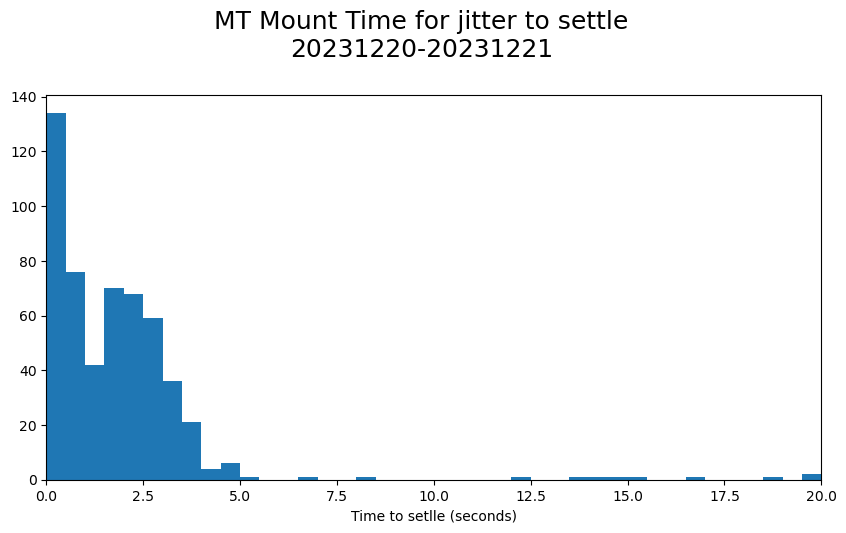

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
plt.suptitle(f"MT Mount Time for jitter to settle\n{firstDayObs}-{lastDayObs}", fontsize = 18, y=1.05)
plt.subplot(1,1,1)
plt.hist(timeToSettles, bins=100, range=(0,50))
plt.xlim(0,20)
plt.xlabel("Time to setlle (seconds)")
plt.savefig(str(dataDir / f"Settling_Time_{firstDayObs}-{lastDayObs}.png"))

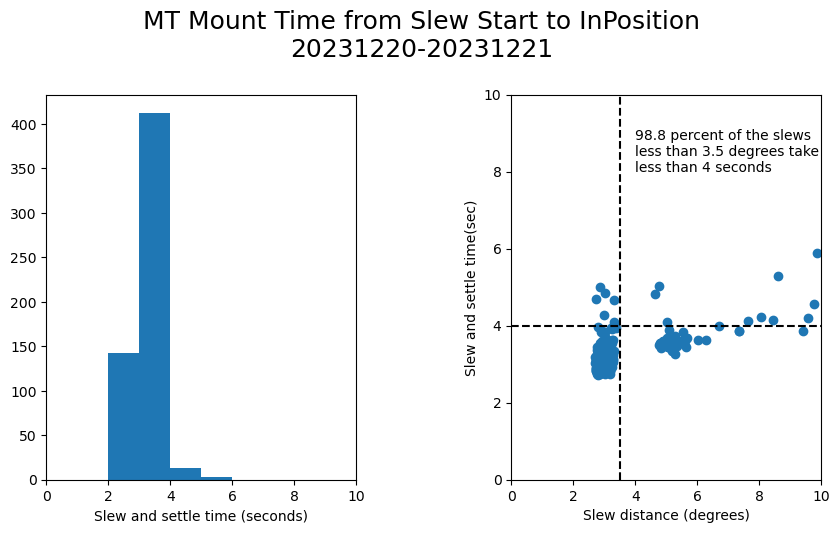

In [7]:
%matplotlib inline
slewsLessThan3p5 = 0
slewsMeetingSpec = 0
for i in range(len(slewTimesInPosition)):
    if slewDistance[i] <= 3.5:
        slewsLessThan3p5 += 1
        if slewTimesInPosition[i] < 4.0:
            slewsMeetingSpec += 1
percentInSpec = slewsMeetingSpec / slewsLessThan3p5 *100.0
fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
plt.suptitle(f"MT Mount Time from Slew Start to InPosition\n{firstDayObs}-{lastDayObs}", fontsize = 18, y=1.05)
plt.subplot(1,2,1)
plt.hist(slewTimesInPosition, bins=50, range=(0,50))
plt.xlim(0,10)
plt.xlabel("Slew and settle time (seconds)")
plt.subplot(1,2,2)
plt.scatter(slewDistance, slewTimesInPosition)
plt.ylabel("Slew and settle time(sec)")
plt.xlabel("Slew distance (degrees)")
plt.plot([3.5,3.5],[0,10], ls='--', color='black')
plt.plot([0,10],[4.0,4.0], ls='--', color='black')
plt.text(4.0, 8.0,f"{percentInSpec:.1f} percent of the slews \nless than 3.5 degrees take \nless than 4 seconds")
plt.xlim(0,10)
plt.ylim(0,10)
plt.savefig(str(dataDir / f"Slew_Settle_Times_InPosition_{firstDayObs}-{lastDayObs}.png"))

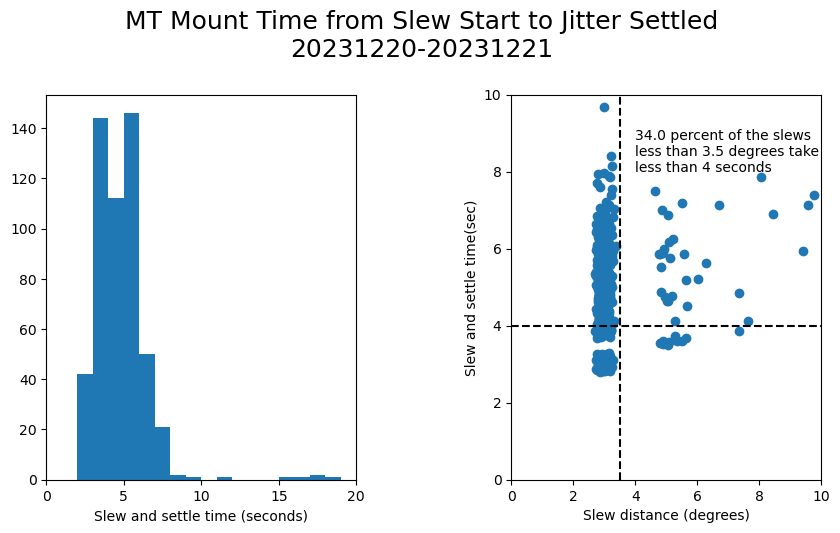

In [8]:
%matplotlib inline
slewsLessThan3p5 = 0
slewsMeetingSpec = 0
for i in range(len(slewTimesSettled)):
    if slewDistance[i] <= 3.5:
        slewsLessThan3p5 += 1
        if slewTimesSettled[i] < 4.0:
            slewsMeetingSpec += 1
percentInSpec = slewsMeetingSpec / slewsLessThan3p5 *100.0

fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
plt.suptitle(f"MT Mount Time from Slew Start to Jitter Settled\n{firstDayObs}-{lastDayObs}", fontsize = 18, y=1.05)
plt.subplot(1,2,1)
plt.hist(slewTimesSettled, bins=50, range=(0,50))
plt.xlim(0,20)
plt.xlabel("Slew and settle time (seconds)")
plt.subplot(1,2,2)
plt.scatter(slewDistance, slewTimesSettled)
plt.ylabel("Slew and settle time(sec)")
plt.xlabel("Slew distance (degrees)")
plt.plot([3.5,3.5],[0,10], ls='--', color='black')
plt.plot([0,10],[4.0,4.0], ls='--', color='black')
plt.text(4.0, 8.0,f"{percentInSpec:.1f} percent of the slews \nless than 3.5 degrees take \nless than 4 seconds")
plt.xlim(0,10)
plt.ylim(0,10)
plt.savefig(str(dataDir / f"Slew_Settle_Times_Settled_{firstDayObs}-{lastDayObs}.png"))

# This plots histograms of the tracking jitter.

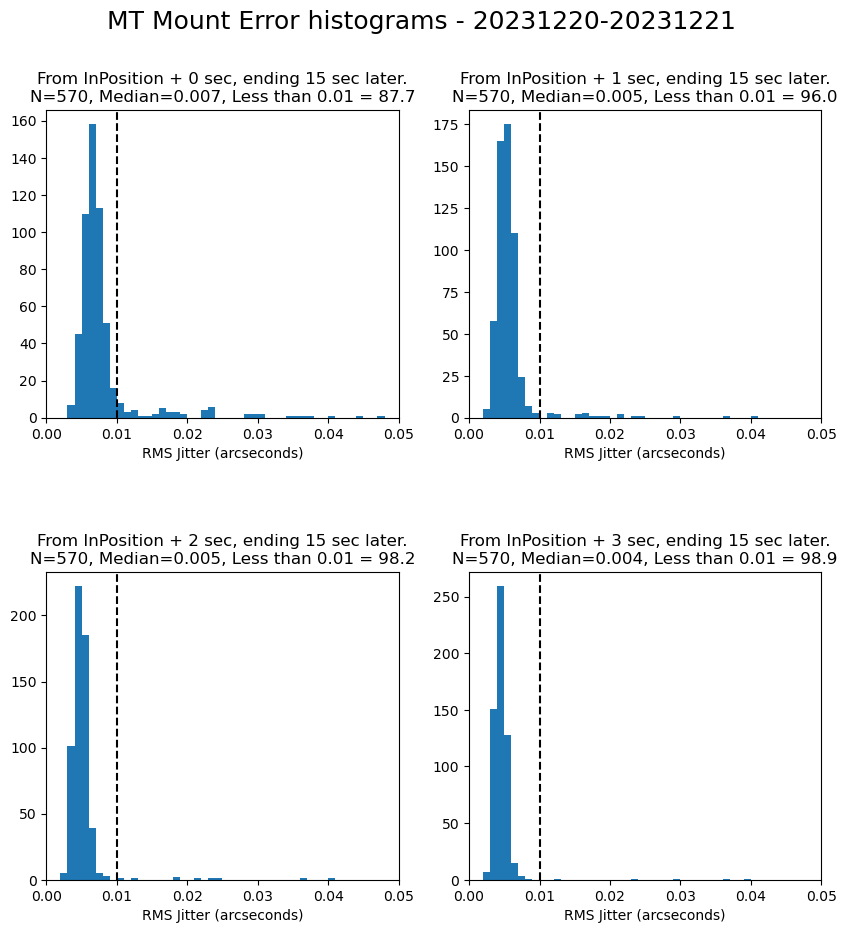

In [13]:
%matplotlib inline
fig, azs = plt.subplots(2,2,figsize=(10,10))
plt.suptitle(f"MT Mount Error histograms - {firstDayObs}-{lastDayObs}", fontsize = 18)#, y=1.05)
plt.subplots_adjust(hspace=0.5)
for i, delay in enumerate(delays):
    azx = i % 2
    azy = int(i / 2)
    rmsError = rmsErrors[delay]
    rmsError = np.array(rmsError)
    goodRms = rmsError[rmsError < 0.01]
    percentGoodRms = len(goodRms) / len(rmsError) * 100.0
    rmsMed = np.nanmedian(rmsError)
    azs[azy][azx].set_title(f"From InPosition + {delay:.0f} sec, ending 15 sec later.\nN={len(rmsError)}, Median={rmsMed:.3f}, Less than 0.01 = {percentGoodRms:.1f}")
    azs[azy][azx].hist(rmsError, range=(0,0.1), bins=100)
    azs[azy][azx].axvline(0.01, color='black', ls = '--')
    azs[azy][azx].set_xlim(0,0.05)
    azs[azy][azx].set_xlabel("RMS Jitter (arcseconds)")
plt.savefig(str(dataDir / f"Jitter_Summary_{firstDayObs}-{lastDayObs}.png"))

# This plots histograms of the tracking error at the beginning of the time period.

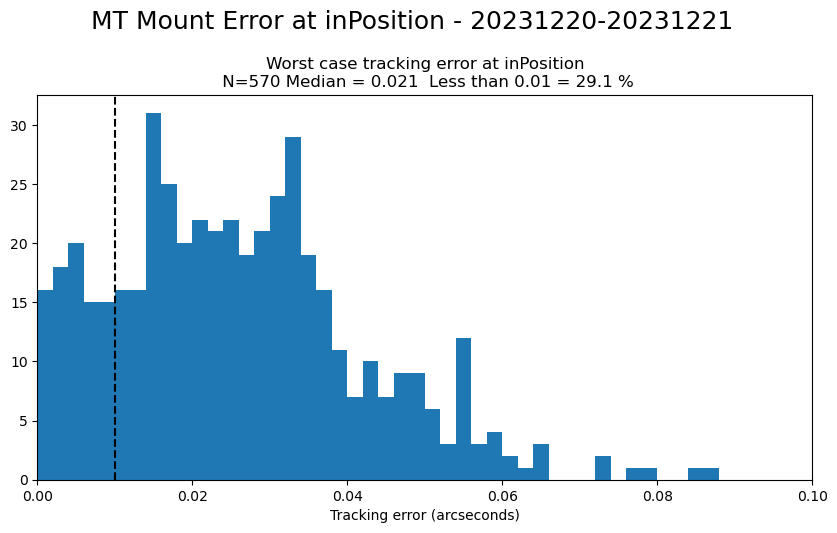

In [14]:
%matplotlib inline
rmsError0s = np.array(rmsError0s)
goodErrors = rmsError0s[rmsError0s < 0.01]
percentGoodErrors = len(goodErrors) / len(rmsError0s) * 100.0
fig = plt.figure(figsize=(10,5))
plt.suptitle(f"MT Mount Error at inPosition - {firstDayObs}-{lastDayObs}", fontsize = 18, y=1.05)
rmsMed = np.nanmedian(rmsError0s)
plt.subplot(1,1,1)
plt.title(f"Worst case tracking error at inPosition\n N={len(rmsError0s)} Median = {rmsMed:.3f}  Less than 0.01 = {percentGoodErrors:.1f} %")
plt.hist(rmsError0s, range=(0,0.1), bins=50)
plt.axvline(0.01, color='black', ls = '--')
plt.xlim(0,0.1)
plt.xlabel("Tracking error (arcseconds)")
plt.savefig(str(dataDir / f"InPosition_Error_{firstDayObs}-{lastDayObs}.png"))